# Microsoft Stock Price Prediction

In [13]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import *

In [ ]:
# Ścieżka do pliku CSV w repozytorium
csv_path = './msft_us_historical_data.csv'

# Sprawdzenie, czy plik istnieje
if not os.path.exists(csv_path):
    # URL do pobrania danych historycznych dla MSFT.US
    url = 'https://stooq.com/q/d/l/?s=msft.us&i=d&d1=20100101&d2=20240101'
    
    # Pobieranie danych
    response = requests.get(url)
    
    # Sprawdzenie, czy żądanie się powiodło
    if response.status_code == 200:
        # Zapisanie danych do pliku CSV w repozytorium
        with open(csv_path, 'wb') as file:
            file.write(response.content)
        
        print(f'Dane zostały pobrane i zapisane do {csv_path}')
    else:
        print(f'Błąd podczas pobierania danych: {response.status_code}')
else:
    print(f'Plik {csv_path} już istnieje')

# Wczytanie danych do DataFrame
df = pd.read_csv(csv_path)

# Wyświetlenie pierwszych kilku wierszy
print(df.head())

# Wyświetlenie podstawowych informacji o danych
print(df.info())

# Zmiana typu kolumny 'Date' na typ daty
df['Date'] = pd.to_datetime(df['Date'])

# LSTM

In [ ]:
# Wybór kolumny 'Close' do predykcji
data = df['Close'].values.reshape(-1, 1)

# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tworzenie sekwencji danych
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Podział na zbiór treningowy i testowy
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# Budowanie modelu LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Trenowanie modelu
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predykcja na zbiorze testowym
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# Przygotowanie danych do wykresu
train_data = data[:split + seq_length]
test_data = data[split + seq_length:]
predicted_data = np.empty_like(data)
predicted_data[:, :] = np.nan
predicted_data[split + seq_length:] = predicted


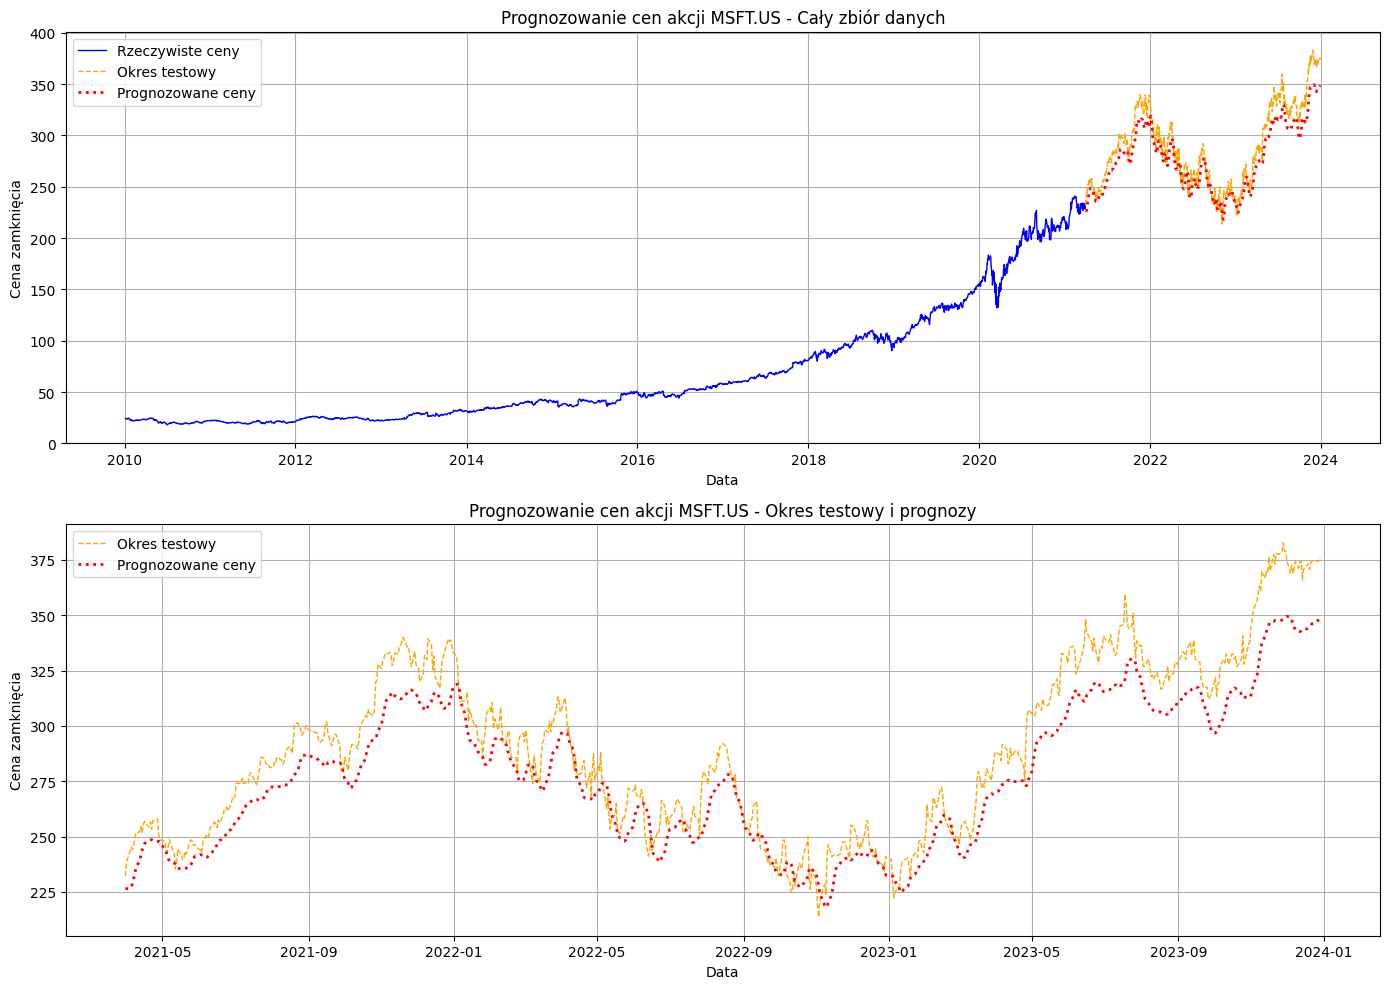

In [32]:
# Wizualizacja wyników
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Wykres całego zbioru danych
ax1.plot(df['Date'][:split + seq_length], data[:split + seq_length], color='blue', label='Rzeczywiste ceny', linewidth=1)
ax1.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
ax1.plot(df['Date'], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
ax1.set_xlabel('Data')
ax1.set_ylabel('Cena zamknięcia')
ax1.set_title('Prognozowanie cen akcji MSFT.US - Cały zbiór danych')
ax1.legend()
ax1.grid(True)

# Wykres przybliżenia okresu testowego i prognoz
ax2.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
ax2.plot(df['Date'][split + seq_length:], predicted, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
ax2.set_xlabel('Data')
ax2.set_ylabel('Cena zamknięcia')
ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [33]:
def build_and_train_model(layers, neurons, optimizer, activation, epochs=20, batch_size=32):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(LSTM(neurons, return_sequences=True, input_shape=(seq_length, 1)))
        elif i == layers - 1:
            model.add(LSTM(neurons))
        else:
            model.add(LSTM(neurons, return_sequences=True))
    model.add(Dense(1, activation=activation))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
    return model, history

In [34]:
def plot_results(df, data, test_data, predicted_data, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Wykres całego zbioru danych
    ax1.plot(df['Date'], data, color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)

    # Dodanie prostokąta zaznaczającego okres testowy
    ax1.axvspan(df['Date'][split + seq_length], df['Date'].iloc[-1], color='grey', alpha=0.3)

    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji MSFT.US - {title}')
    ax1.legend()
    ax1.grid(True)

    # Wykres przybliżenia okresu testowego i prognoz
    ax2.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length:], predicted_data[split + seq_length:], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Parametry do przetestowania
layers_options = [1, 2, 3, 4]
neurons_options = [50, 100, 150, 200]
optimizers_options = [Adam(), RMSprop(), SGD(), Adagrad()]
activations_options = ['relu', 'tanh', 'sigmoid', 'linear']
batch_sizes = [16, 32, 64, 128]


# Przechowywanie wyników
results = []

# Testowanie wpływu liczby warstw
for layers in layers_options:
    model, history = build_and_train_model(layers, 50, Adam(), 'relu')
    loss = history.history['val_loss'][-1]
    results.append(('layers', layers, loss))
    print(f'Layers: {layers}, Loss: {loss}')
    
    # Predykcja na zbiorze testowym
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted)
    
    # Przygotowanie danych do wykresu
    predicted_data = np.empty_like(data)
    predicted_data[:, :] = np.nan
    predicted_data[split + seq_length:] = predicted
    
    # Rysowanie wykresu
    plot_results(df, data, test_data, predicted_data, f'Liczba warstw: {layers}')

# Testowanie wpływu liczby neuronów
for neurons in neurons_options:
    model, history = build_and_train_model(2, neurons, Adam(), 'relu')
    loss = history.history['val_loss'][-1]
    results.append(('neurons', neurons, loss))
    print(f'Neurons: {neurons}, Loss: {loss}')
    
    # Predykcja na zbiorze testowym
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted)
    
    # Przygotowanie danych do wykresu
    predicted_data = np.empty_like(data)
    predicted_data[:, :] = np.nan
    predicted_data[split + seq_length:] = predicted
    
    # Rysowanie wykresu
    plot_results(df, data, test_data, predicted_data, f'Liczba neuronów: {neurons}')

# Testowanie wpływu optymalizatora
for optimizer in optimizers_options:
    model, history = build_and_train_model(2, 50, optimizer, 'relu')
    loss = history.history['val_loss'][-1]
    results.append(('optimizer', optimizer.__class__.__name__, loss))
    print(f'Optimizer: {optimizer.__class__.__name__}, Loss: {loss}')
    
    # Predykcja na zbiorze testowym
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted)
    
    # Przygotowanie danych do wykresu
    predicted_data = np.empty_like(data)
    predicted_data[:, :] = np.nan
    predicted_data[split + seq_length:] = predicted
    
    # Rysowanie wykresu
    plot_results(df, data, test_data, predicted_data, f'Optymalizator: {optimizer.__class__.__name__}')

# Testowanie wpływu funkcji aktywacji
for activation in activations_options:
    model, history = build_and_train_model(2, 50, Adam(), activation)
    loss = history.history['val_loss'][-1]
    results.append(('activation', activation, loss))
    print(f'Activation: {activation}, Loss: {loss}')
    
    # Predykcja na zbiorze testowym
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted)
    
    # Przygotowanie danych do wykresu
    predicted_data = np.empty_like(data)
    predicted_data[:, :] = np.nan
    predicted_data[split + seq_length:] = predicted
    
    # Rysowanie wykresu
    plot_results(df, data, test_data, predicted_data, f'Funkcja aktywacji: {activation}')

# Testowanie wpływu wielkości batch size
for batch_size in batch_sizes:
    model, history = build_and_train_model(2, 50, Adam(), 'relu', batch_size=batch_size)
    loss = history.history['val_loss'][-1]
    results.append(('batch_size', batch_size, loss))
    print(f'Batch size: {batch_size}, Loss: {loss}')
    
    # Predykcja na zbiorze testowym
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted)
    
    # Przygotowanie danych do wykresu
    predicted_data = np.empty_like(data)
    predicted_data[:, :] = np.nan
    predicted_data[split + seq_length:] = predicted
    
    # Rysowanie wykresu
    plot_results(df, data, test_data, predicted_data, f'Batch size: {batch_size}')

C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Layers: 1, Loss: 0.0048766667023301125
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


ValueError: Found array with dim 3. None expected <= 2.